# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [7]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import cv2
from skimage.transform import rotate
import glob

training_file = '../data/train.p' # '../data/mod_train0.p'  '../data/train.p'
testing_file = '../data/test.p'  # '../data/mod_test0.p'    '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

n_train = len(X_train)
n_test = len(X_test)
n_classes = len(set(y_train))
image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualization of the dataset:

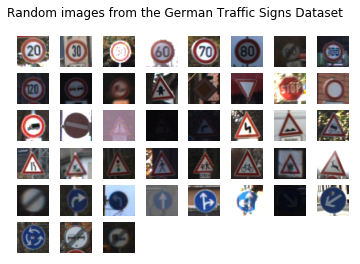

In [9]:
### Data exploration visualization code goes here.
%matplotlib inline

# select and show a random sample from each class
rows, cols = 6, 8
fig, axs = plt.subplots(rows, cols)
plt.suptitle('Random images from the German Traffic Signs Dataset ')
for sign_class_idx, ax in enumerate(axs.ravel()):
    if sign_class_idx < n_classes:
        sign_class_img_set = X_train[y_train == sign_class_idx]
        sign_class_rnd_img = sign_class_img_set[np.random.randint(len(sign_class_img_set))]
        ax.imshow(sign_class_rnd_img)
        #ax.set_title('{:02d}'.format(sign_class_idx), fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')
# hide x and y ticks
plt.setp([a.get_xticklabels() for a in axs.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in axs.ravel()], visible=False)
plt.show()

Histogram plotting of the original training data set shows that some classes may not have enough data required for high accuracy recognition. Secondly, distribution of the test data on the other side is quite similar to the train data, so I would expect that sign recognition will not be biased to a particular sign.

Text(0,0.5,'Counts')

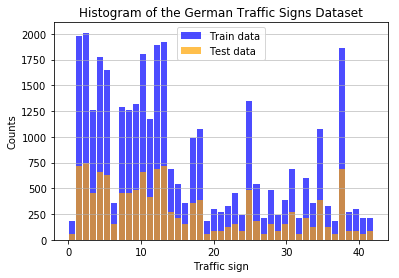

In [10]:
plt.hist(y_train, bins=n_classes, color='blue', alpha=0.7, rwidth=0.85)
plt.hist(y_test, bins=n_classes, color='orange', alpha=0.7, rwidth=0.85)
plt.legend(["Train data", "Test data"])
plt.grid(axis='y', alpha=0.75)
plt.title('Histogram of the German Traffic Signs Dataset')
plt.xlabel('Traffic sign')
plt.ylabel('Counts')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

To improve the accuracy the first thing I did I increased the data set size. Initially, I implemented several steps: rotation, warping, shifting the images in x and y coordinates. But the data size increased hugely so that my pc would run out of memory very quickly. At the end, I just keept only image rotation option and the data set increased by 5.

In [11]:
def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

In [13]:
aug_mode = 1 # =1 generated augmented data set
             # =0 load already generated augmented data set
    
save_aug_img = 0
num_rot = 5 # number of rotations per image

mod_training_file = '../data/mod_train0.p'

if 1 == aug_mode:
     # # generated augmented data set
    y_train1 = np.matlib.repmat(y_train, num_rot, 1)
    y_train1 = y_train1.T.reshape(-1)
    X_train1 = np.zeros([len(X_train)*num_rot, 32, 32, 3], dtype=np.uint8)
    for idx in range(len(X_train)):
        for idx1 in range(num_rot):
            k = idx * num_rot + idx1
            # convert it back to 8 bytes, i.e. saves memory by factor 8 
            X_train1[k, :, :, :] = np.uint8(rotate_image(X_train[idx, :, :, :], max_angle=15)*255.0)

    X_train, y_train = X_train1, y_train1
    
    if 1 == save_aug_img:
        with open(mod_training_file, mode='wb') as f:
            pickle.dump({'features': X_train, 'labels': y_train}, f)
else:
    # load already generated augmented data set
    with open(mod_training_file, mode='rb') as f:
        train = pickle.load(f)
    X_train, y_train = train['features'], train['labels']


After some trying I just kept the straight forward normalization:

In [14]:
# Normalise input
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

In [15]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=60)

Other things I tried shortly were playing with color spaces (YUV for example as mentioned here [[LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)
 and gray colorspace) and histogram equalization. But haven't seen much of a progress nor I wanted to use more of GPU time.

### Model Architecture

With LeNet architecture I reached 94% accuracy. After that I slightly modified it, I removed one of the fully connected layers and increased the depth of the activation volume instead. The idea here was to increase the depth column in order to get more details as mentioned in [[LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) "In the case of 2 stages of features, the second stage extracts
“global” and invariant shapes and structures, while the first
stage extracts “local” motifs with more precise details." 

In [16]:
BATCH_SIZE = 128
EPOCHS = 10

rate = 0.001

mu = 0
sigma = 0.1

conv1_depth = 64 
conv2_depth = 128
fc1_depth = 64
fc2_depth = n_classes

last_saved_epoch = 0 # not a parameter, don't change it

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, conv1_depth), mean=mu, stddev=sigma), name='weights_0')
conv1_b = tf.Variable(tf.zeros(conv1_depth), name='bias_0')
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_depth, conv2_depth), mean=mu, stddev=sigma), name='weights_1')
conv2_b = tf.Variable(tf.zeros(conv2_depth), name='bias_1')
fc1_W = tf.Variable(tf.truncated_normal(shape=(5*5*conv2_depth, fc1_depth), mean=mu, stddev=sigma), name='weights_2')
fc1_b = tf.Variable(tf.zeros(fc1_depth), name='bias_2')
fc2_W = tf.Variable(tf.truncated_normal(shape=(fc1_depth, fc2_depth), mean=mu, stddev=sigma), name='weights_3')
fc2_b = tf.Variable(tf.zeros(fc2_depth), name='bias_3')

def ConvNet(x):

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x64.
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x64. Output = 14x14x64.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x128.
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x128. Output = 5x5x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x128. Output = 3200.
    fc0 = flatten(conv2)
    # Layer 3: Fully Connected. Input = 3200. Output = 64.
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 64. Output = 43.
    logits = tf.matmul(fc1, fc2_W) + fc2_b

    return logits
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = ConvNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [18]:
#Model Evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
#Train the Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if (i % 3) == 0:
            saver.save(sess, './lenet_epoch'+str(i + 1)+'.ckpt')
            last_saved_epoch = i + 1
            print("Model saved")


### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

Training...

EPOCH 1 ...
Training Accuracy = 0.986
Validation Accuracy = 0.983

Model saved
EPOCH 2 ...
Training Accuracy = 0.993
Validation Accuracy = 0.990

EPOCH 3 ...
Training Accuracy = 0.995
Validation Accuracy = 0.993

EPOCH 4 ...
Training Accuracy = 0.997
Validation Accuracy = 0.995

Model saved
EPOCH 5 ...
Training Accuracy = 0.997
Validation Accuracy = 0.996

EPOCH 6 ...
Training Accuracy = 0.996
Validation Accuracy = 0.995

EPOCH 7 ...
Training Accuracy = 0.999
Validation Accuracy = 0.998

Model saved
EPOCH 8 ...
Training Accuracy = 0.999
Validation Accuracy = 0.998

EPOCH 9 ...
Training Accuracy = 0.997
Validation Accuracy = 0.996

EPOCH 10 ...
Training Accuracy = 0.999
Validation Accuracy = 0.999

Model saved


In [32]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_epoch10.ckpt
Test Accuracy = 0.956


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

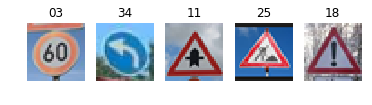

In [34]:
images_new = glob.glob('../data/'+'*.jpg')
images_new = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)  for img in images_new]
y_new = [3, 34, 11, 25, 18]  # class id's

fig, axs = plt.subplots(1, len(images_new))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images_new[idx])
    ax.set_title('{:02d}'.format(y_new[idx]))
    ax.axis('off')


### Predict the Sign Type for Each Image

In [35]:
# normalize
for idx in range(len(images_new)):
    images_new[idx] = (images_new[idx] - np.min(images_new[idx])) / (np.max(images_new[idx]) - np.min(images_new[idx]))
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: images_new})), axis=1)

for i, pred in enumerate(prediction):
    print('Target = {:02d} | Predicted = {:02d}'.format(y_new[i], pred))
    
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

INFO:tensorflow:Restoring parameters from ./lenet_epoch10.ckpt
Target = 03 | Predicted = 03
Target = 34 | Predicted = 34
Target = 11 | Predicted = 11
Target = 25 | Predicted = 25
Target = 18 | Predicted = 18


### Analyze Performance

In [36]:
print('Test Accuracy = {:.3f}'.format(np.sum(y_new == prediction) / len(y_new)))
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

Test Accuracy = 1.000


The images used are actually "good" and easily detectable images, so it is not a surprise that accuracy is 100%.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet_epoch10.ckpt


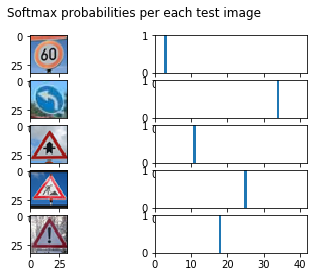

In [37]:
# visualizing softmax probabilities
num_tops = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(tf.nn.top_k(logits, k=num_tops), feed_dict={x: images_new})
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: images_new})

# plot softmax probabilities per each test image
n_images = len(images_new)
fig, axs = plt.subplots(n_images, 2)
plt.suptitle('Softmax probabilities per each test image')
for idx in range(0, n_images):
    axs[idx, 0].imshow(images_new[idx])
    axs[idx, 1].bar(np.arange(n_classes), softmax_probs[idx])
    axs[idx, 1].set_ylim([0, 1])
    axs[idx, 1].set_xlim([0, n_classes-1])


In [38]:
# Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
for img_idx in range(len(images_new)):
    print()
    print('Top predictions for the target image {:02d}'.format(y_new[img_idx]))
    for idx_within_tops in range(num_tops):
        pred_img = top_k[1][img_idx][idx_within_tops]
        probability = softmax_probs[img_idx][pred_img]
        print('Predicted {:02d} with probability {:.5f}'.format(pred_img, probability))
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


Top predictions for the target image 03
Predicted 03 with probability 1.00000
Predicted 05 with probability 0.00000
Predicted 01 with probability 0.00000
Predicted 11 with probability 0.00000
Predicted 06 with probability 0.00000

Top predictions for the target image 34
Predicted 34 with probability 1.00000
Predicted 36 with probability 0.00000
Predicted 19 with probability 0.00000
Predicted 35 with probability 0.00000
Predicted 38 with probability 0.00000

Top predictions for the target image 11
Predicted 11 with probability 1.00000
Predicted 30 with probability 0.00000
Predicted 27 with probability 0.00000
Predicted 24 with probability 0.00000
Predicted 28 with probability 0.00000

Top predictions for the target image 25
Predicted 25 with probability 1.00000
Predicted 05 with probability 0.00000
Predicted 14 with probability 0.00000
Predicted 29 with probability 0.00000
Predicted 30 with probability 0.00000

Top predictions for the target image 18
Predicted 18 with probability 1.000

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")